# TRABAJO PRÁCTICO 10 - Gaussian Variational Bayes

In [439]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import digamma, gamma, logsumexp

# Creación del dataset

#### Generar 100 muestras de una mezcla de gaussianas con pesos: 0.1, 0.4, 0.2, 0.3, medias −4, 0, 4, 5 y varianzas 1, 1.96, 1.44, 1 respectivamente.

In [440]:
# Se cargan los datos correspondientes

ORIGINAL_WEIGHTS = np.array([0.1, 0.4, 0.2, 0.3])
ORIGINAL_MEANS = np.array([-4,0,4,5])
ORIGINAL_VARS = np.array([1, 1.96, 1.44, 1])

original_weights = ORIGINAL_WEIGHTS
original_means = ORIGINAL_MEANS
original_vars = ORIGINAL_VARS

N_BEHAVIOR = 6

# Se coloca una semilla común a fines de reproducibilidad
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

original_stds = np.sqrt(original_vars)

n_samples = 100
K_original = original_weights.shape[0]

# Se definen la cantidad de muestras que aportan cada una de las componentes al total de muestras
samples_per_component = (n_samples * original_weights).astype(int)

# Se crean los arrays de medias y desviaciones estándar, en función de la cantidad de muestras para cada gaussiana.
# Por ejemplo, para la media -4, se generan 10 elementos de igual valor y así para cada media en base a samples_per_component
means_samples = np.repeat(original_means, samples_per_component)

stds_samples = np.repeat(original_stds, samples_per_component)

# Se crea el dataset. Generará una muestra proveniente de cada gaussiana, con parámetros (mean, std), por lo que se tendrán 100 muestras
X = np.random.normal(loc=means_samples, scale=stds_samples, size=n_samples)



print("X:", X.shape)

X: (100,)


# K-Means

#### Implementar un algoritmo de K-means para caracterizar la puntualidad de los estudiantes. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos init, fit y predict.

In [441]:
class KMeans :
    
    #Inicialización de atributos y declaración de hiperparámetros
    def __init__ (self, n_clusters = 6, max_iter = 100, random_state = RANDOM_STATE, tol = 1e-3):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state #Para la elección pseudo-aleatoria de los centroides iniciales
        self.centroids = None
        self.tol = tol
        self.y = None




    ############################################ Entrenamiento
    def fit (self, X):

        # Si X es de 1 dimensión, se hace un reshape para que sea de tamaño (X.shape[0], 1) y evitar errores
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        if self.random_state != None:
            np.random.seed(self.random_state)

        #------------------- Se inicializan los centroides, como un elemento aleatorio de X

        n_samples = X.shape[0]

        #Seleccion sin reposicion de la muestra
        random_idx = np.random.choice(n_samples, self.n_clusters, replace=False) 

        #Se asignan los centroides iniciales como la muestra aleatoria
        self.centroids = X[random_idx] 
        
        #------------------- Se itera para  calcular los nuevos centroides y obtener las etiquetas

        for i in range(self.max_iter):

            #Se calculan las distancias a los centroides
            distances = self.distance_centr(X) 

            #Se etiqueta cada muestra con un cluster, según el centroide más cercano 
            self.y= np.argmin(distances, axis= 0) 

            #Se recalculan los K centroides, como la media de los datos pertenecientes al mismo cluster
            new_centroids  = np.array([X[self.y == k].mean(axis=0) for k in range(self.n_clusters)]) 
            
            #Se verifica si los centroides actuales no se diferencian mucho del previo como condición de corte (convergencia)
            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) < self.tol):
                break

            #Se actualizan los centroides
            self.centroids = new_centroids 

        return self.centroids







    ############################################ Predicción Hard
    def predict(self, X):

        #Se calculan las distancias a los centroides tras el entrenamiento
        distances = self.distance_centr(X)

        #Se retornan las etiquetas correspondientes al centroide más cercano
        return np.argmin(distances, axis= 0) 
    

    def fit_predict(self,X):
        self.fit(X)
        return self.predict(X)

    ############################################ Calcula las distancias de las muestras X a los centroides
    def distance_centr(self, X):
        distances= []
        for k in range(self.n_clusters):
            dis = np.array([np.sqrt(np.sum((X[i,:]-self.centroids[k])**2)) for i in range(X.shape[0])])
            distances.append(dis)

        return np.array(distances)

#### Modelar una mezcla de gaussianas con los resultados del entrenamiento. Las medias sean los centroides, las varianzas sean estimadas intra-clase y los pesos sean la proporción de las muestras.

In [442]:
kmeans_model = KMeans(n_clusters = N_BEHAVIOR)

# Se entrena KMeans con el dataset generado previamente
kmeans_model.fit(X)

# Se asigna la cantidad de clases como la cantidad de clusters de kmeans
K_kmeans = kmeans_model.n_clusters

# Se asignan las medias del gmm como los centroides de kmeans
means_kmeans = kmeans_model.centroids

# Se inicia una lista para las varianzas provenientes de kmeans
vars_kmeans = []

# Se inicializa una lista para los pesos calculados a partir de los datos de entrenamiento de kmeans
weights_kmeans = []

for k in range(K_kmeans):

    # Se seleccionan los datos pertenecientes al cluster k
    x_k = X[kmeans_model.y == k]

    # Se calcula la varianza de los datos pertenecientes al cluster k (varianza intra-clase)
    var_k = np.var(x_k)

    # Se carga en la lista de las varianzas de los gmm, la varianza de dicho cluster
    vars_kmeans.append(var_k)

    # Se calcula el peso de la clase k, como la cantidad de muestras de esta clase con respecto al total de muestras
    weight_k = x_k.shape[0] / X.shape[0]

    # Se carga el peso de la clase k en la lista de pesos para el gmm
    weights_kmeans.append(weight_k)

# Se pasa a array de numpy la lista de varianzas para el gmm
vars_kmeans = np.asarray(vars_kmeans)

# Se guarda la desviación estándar para el gmm
stds_kmeans = np.sqrt(vars_kmeans)

# Se pasa a array de numpy la lista de pesos para el gmm
weights_kmeans = np.asarray(weights_kmeans)

# Se aplana el array para evitar que sea 2D
means_kmeans = means_kmeans.ravel()

# print('means_kmeans: ', means_kmeans.shape)
# print('vars_kmeans: ', vars_kmeans.shape)
# print('weights_kmeans: ', weights_kmeans.shape)

# Se calculan las muestras para cada componente de la mezcla utilizando los pesos
samples_per_component_kmeans = (n_samples * weights_kmeans).astype(int)

# Se obtienen las medias para cada una de las muestras de cada una de las componentes de la mezcla
means_kmeans_samples = np.repeat(means_kmeans, samples_per_component_kmeans)

# Se obtienen las desviaciones estándar para cada una de las muestras de cada una de las componentes de la mezcla
stds_kmeans_samples = np.repeat(stds_kmeans, samples_per_component_kmeans)

# Se obtienen las muestras de las gaussianas, utilizando las medias y desviaciones estándar calculadas previamente
gmm_from_kmeans = np.random.normal(loc=means_kmeans_samples, scale=stds_kmeans_samples, size=n_samples)

#### Graficar la densidad estimada y compararla con la original.

##### Funciones

In [443]:
def gaussian_pdf (x, mean, std):
    coefficient = 1.0 / (std * np.sqrt(2 * np.pi))
    exponent = -0.5 * ((x - mean) / std)**2
    return coefficient * np.exp(exponent)


# Esta función recibe un dataset X, que se estima proviene de una mezcla de gaussianas y realiza una estimación de la pdf de dicho dataset
# Recibe además, los parámetros de KMeans, además de n_pdf (cantidad de muestras que se desean de la pdf)
# Retorna x e y de la pdf y la cantidad de componentes (n_clusters)
def estimate_pdf_kmeans (X, n_clusters = 6, n_pdf =500):

    kmeans_model = KMeans(n_clusters)

    # Se entrena KMeans con el dataset
    kmeans_model.fit(X)

    # Se asigna la cantidad de clases como la cantidad de clusters de kmeans
    K_kmeans = kmeans_model.n_clusters

    # Se asignan las medias del gmm como los centroides de kmeans
    means_kmeans = kmeans_model.centroids

    # Se inicia una lista para las varianzas provenientes de kmeans
    vars_kmeans = []

    # Se inicializa una lista para los pesos calculados a partir de los datos de entrenamiento de kmeans
    weights_kmeans = []

    for k in range(K_kmeans):

        # Se seleccionan los datos pertenecientes al cluster k
        x_k = X[kmeans_model.y == k]

        # Se calcula la varianza de los datos pertenecientes al cluster k (varianza intra-clase)
        var_k = np.var(x_k)

        # Se carga en la lista de las varianzas de los gmm, la varianza de dicho cluster
        vars_kmeans.append(var_k)

        # Se calcula el peso de la clase k, como la cantidad de muestras de esta clase con respecto al total de muestras
        weight_k = x_k.shape[0] / X.shape[0]

        # Se carga el peso de la clase k en la lista de pesos para el gmm
        weights_kmeans.append(weight_k)

    # Se pasa a array de numpy la lista de varianzas para el gmm
    vars_kmeans = np.asarray(vars_kmeans)

    # Se guarda la desviación estándar para el gmm
    stds_kmeans = np.sqrt(vars_kmeans)

    # Se pasa a array de numpy la lista de pesos para el gmm
    weights_kmeans = np.asarray(weights_kmeans)

    # Se aplana el array para evitar que sea 2D
    means_kmeans = means_kmeans.ravel()

    print('K_kmeans: ', K_kmeans)
    print('weights_kmeans: ', weights_kmeans.shape)
    print('variances_kmeans: ',stds_kmeans.shape)
    print('means_kmeans: ', means_kmeans.shape)

    # Se generan los datos para la pdf
    x_pdf = np.linspace(np.min(X)-1 , np.max(X)+1 ,n_pdf)

    # Se genera un array de ceros del mismo tamaño que x_plot, que se utilizará para guardar la pdf original y la estimada
    estimated_pdf = np.zeros_like(x_pdf)

    # Se estima la pdf utilizando los parámetros estimados por KMeans
    for k in range(K_kmeans):
        # Se estima la componente de la pdf, usando los parámetros de KMeans
        component_estimated_pdf = gaussian_pdf(x_pdf, mean = means_kmeans[k], std = stds_kmeans[k])

        # Se estima la pdf de la mezcla utilizando los pesos
        estimated_pdf  += weights_kmeans[k] * component_estimated_pdf

    return x_pdf,estimated_pdf,K_kmeans

def pdf_original (n_plot = 500):

    # Se cargan los datos correspondientes 
    original_weights = ORIGINAL_WEIGHTS
    original_means = ORIGINAL_MEANS
    original_vars = ORIGINAL_VARS
    original_stds = np.sqrt(original_vars)

    K_original = original_weights.shape[0]

    

    x_plot = np.linspace(np.min(X)-1 , np.max(X)+1 ,n_plot)

    # Se crea el array de ceros de igual tamaño que x_plot
    original_pdf = np.zeros_like(x_plot)

    # Se calcula la pdf de los datos originales
    for k in range(K_original):

        # Se calcula la pdf de la componente k, utilizando las medias y desviaciones estándar
        component_original_pdf = gaussian_pdf(x_plot, mean = original_means[k], std = original_stds[k])

        # Se suma la componente k a la mezcla
        original_pdf  += original_weights[k] * component_original_pdf


##### Gráficos

K_original:  4
K_estimated:  6


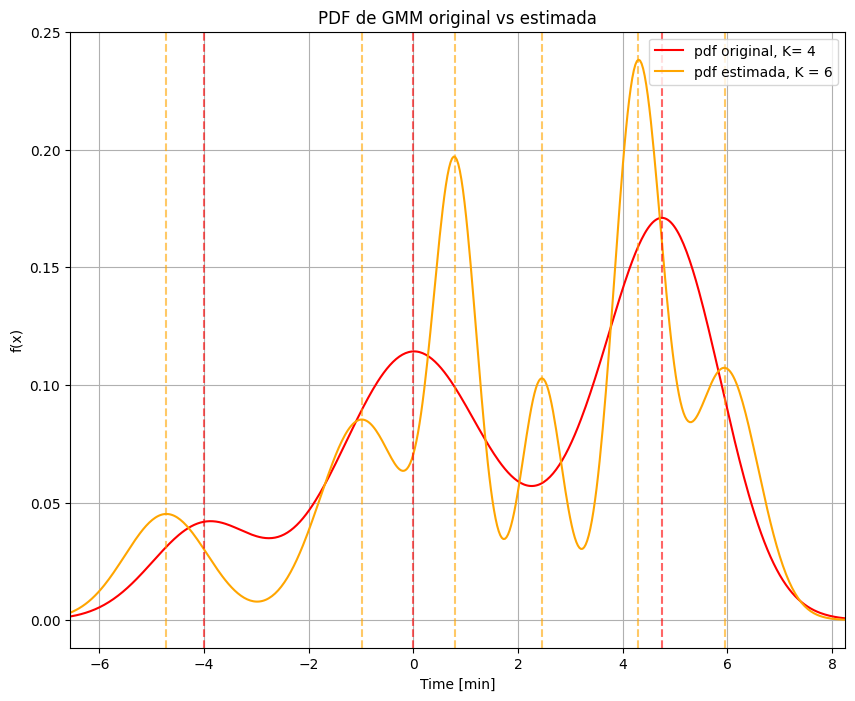

In [444]:

# Se generan los datos para graficar
n_plot = 500
x_plot = np.linspace(np.min(X)-1 , np.max(X)+1 ,n_plot)

# Se genera un array de ceros del mismo tamaño que x_plot, que se utilizará para guardar la pdf original y la estimada
original_pdf = np.zeros_like(x_plot)
estimated_pdf = np.zeros_like(x_plot)

# Se calcula la pdf de los datos originales
for k in range(K_original):

    # Se calcula la pdf de la componente k, utilizando las medias y desviaciones estándar
    component_original_pdf = gaussian_pdf(x_plot, mean = original_means[k], std = original_stds[k])

    # Se suma la componente k a la mezcla
    original_pdf  += original_weights[k] * component_original_pdf

# Se calcula la pdf de la estimación con kmeans
for k in range(K_kmeans):

    # Se calcula la pdf de la componente k, utilizando las medias y desviaciones estándar
    component_estimated_pdf = gaussian_pdf(x_plot, mean = means_kmeans[k], std = stds_kmeans[k])

    # Se suma la componente k a la mezcla 
    estimated_pdf  += weights_kmeans[k] * component_estimated_pdf



#### GRAFICOS

vlines1 = [original_means[0], original_means[1], 4.75] 
vlines2 = means_kmeans.tolist()

color1 = 'red'
color2 = 'orange'

plt.figure(figsize=(10,8))
plt.plot(x_plot,original_pdf, label = f'pdf original, K= {K_original}', color = color1)
plt.plot(x_plot,estimated_pdf, label = f'pdf estimada, K = {K_kmeans}', color=color2)


#### Se grafican las lineas verticales y se reinician los colores
plt.gca().set_prop_cycle(None)

for v in vlines1:
    plt.axvline(v, color=color1, linestyle="--", alpha=0.6)

for v in vlines2:
    plt.axvline(v, color=color2, linestyle="--", alpha=0.6)


# #### Se especifica que los valores del eje tengan solo 1 decimal
# plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1f}"))

# #### Se colocan los valores para cada una de las medias en el eje de tiempo
# all_vlines = vlines1+vlines2

# #Se remueven duplicados y se ordena
# xticks = sorted(list(set(all_vlines))) 

# #Se agregan los valores al eje x
# plt.xticks(xticks)  


plt.xlabel('Time [min]')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.xlim([np.min(x_plot),np.max(x_plot)])
plt.title('PDF de GMM original vs estimada')

print('K_original: ', K_original)
print('K_estimated: ', K_kmeans)


En este caso, se puede apreciar que, en la densidad original, se muestran 3 comportamientos claros, con gran probabilidad. El algoritmo KMeans, sobreestima estos tiempos, asignándoles probabilidades mayores y forzando la aparición de los 6 clusters. Esto genera que KMeans no realice una buena aproximación a la densidad de los datos dados. KMeans fuerza una gaussiana por cluster, todas con distinta media (centroides) y varianza. Por otro lado, KMeans para la asignación de clusters, supone que son esféricos, por lo que la distribución de los datos en clusters puede no ser correcta según la geometría de los datos dispersos.

# EM (Expectation - Maximization)

#### Implementar un algoritmo de EM para caracterizar la puntualidad de los estudiantes. Inicializar el algoritmo con el modelo de K-means. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo EM debe ser definido dentro de una clase que posea al menos los métodos init, fit, predict_proba y predict.

In [445]:
class EM:

    ########################################################## Inicializar atributos y declaración de hiperparámetros
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=RANDOM_STATE):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means = None
        self.covariances = None
        self.weights = None
        self.resp = None





    ########################################################## Etapa de entrenamiento
    def fit(self, X):

        # Se adapta a vector 2D para evitar errores
        if X.ndim == 1: 
            X = X.reshape(-1,1)

        if self.random_state != None: 
            np.random.seed(self.random_state)

        n_samples, n_dim = X.shape #Se extraen la cantidad de muestras y las features (2 dimensiones)

        #------------------- Inicialización de los parámetros con K-Means

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state, max_iter=self.max_iter)
        
        y = kmeans.fit_predict(X)

        self.means = kmeans.centroids

        #Se calculan las covarianzas de las muestras de cada cluster
        self.covariances = np.array([[[np.cov(X[y == k].T)]] for k in range(self.n_clusters)])

        #Se asignan los pesos de cada cluster como la media de las etiquetas de cada uno de ellos
        self.weights = np.array([np.mean(y == k) for k in range(self.n_clusters)])
        

        #------------------- Algoritmo EM

        #Se inicializa la log-verosimilitud previa como 0
        log_likelihood_old = 0

        
        for _ in range(self.max_iter):
            #-------------------------- Paso E (Expectation)

            self.resp = np.zeros((n_samples, self.n_clusters))

            for k in range(self.n_clusters):

                #Se calcula la probabilidad condicional de que la muesta Xi pertenezca al cluster k, dados los parámetros y la ocurrencia de Xi
                self.resp[:, k] = self.weights[k] * self.multivariate_normal_pdf(
                    X, mean=self.means[k], cov=self.covariances[k]
                )

            #Se normaliza la probabilidad condicional previa, para que sume 1
            self.resp = self.resp / np.sum(self.resp, axis=1, keepdims=True)

            # print(self.resp.shape) #Se obtiene una matriz de n_samples x n_dim

            #-------------------------- Paso M (Maximization)

            #Se calculan la cantidad de puntos de cada cluster de forma "efectiva"
            Nk = np.sum(self.resp, axis=0)

            #Se actualizan los pesos de los clusters
            self.weights = Nk / n_samples

            #Se actualizan las medias. Cada muestra se multiplica por la condicional asociada y se divide por Nk
            self.means = (self.resp.T @ X) / Nk.reshape(-1,1) #Se convierte a un array 2D

            #Se crea un array de ceros para las matrices de covarianza de cada cluster
            self.covariances = np.zeros((self.n_clusters, n_dim, n_dim)) 
            
            #Se actualizan las covarianzas de cada cluster
            for k in range(self.n_clusters):

                #Se calcula la diferencia de las muestras con respecto a la media 
                diff = X - self.means[k] 

                #Se calculan las covarianzas
                self.covariances[k] = (self.resp[:, k].reshape(-1, 1) * diff).T @ diff / Nk[k] 
            

            #Se obtiene la log-verosimilitud, es decir, la suma de los logaritmos de las probabilidades condicionales
            log_likelihood = np.sum(np.log(np.sum([
                self.weights[k] * self.multivariate_normal_pdf(X, self.means[k], self.covariances[k])
                for k in range(self.n_clusters)
            ], axis=0)))

            #Se fija una condición de corte cuando la verosimilitud no cambia en el rango de tolerancia
            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break

            #Se actualiza la log-verosimilitud
            log_likelihood_old = log_likelihood

            




    ########################################################## Testeo soft
    def predict_soft(self, X):

        if X.ndim == 1:
            X = X.reshape(-1,1)

        n_samples = X.shape[0]
        resp = np.zeros((n_samples, self.n_clusters))
        
        #Se calculan las probabilidades condicionales como se realizó en el fit
        for k in range(self.n_clusters):
            resp[:, k] = self.weights[k] * self.multivariate_normal_pdf(
                X, mean=self.means[k], cov=self.covariances[k]
            )
        
        #Se normaliza la condicional para que las filas sumen 1
        resp /= resp.sum(axis=1, keepdims=True)
        return resp
    



    
    ########################################################## Testeo hard
    def predict(self, X):

        if X.ndim == 1:
            X = X.reshape(-1,1)

        #Se obtienen las probabilidades de pertenecer a cada uno de los clusters de cada muestra
        resp = self.predict_soft(X)
        
        #Se asigna cada muestra al cluster con mayor probabilidad
        return np.argmax(resp, axis=1)




    ########################################################## fit + predict
    def fit_predict(self, X) : 
        self.fit(X)
        return self.predict(X)
    



    ########################################################## Función que calcula función de densidad de una Gaussiana Multivariable
    def multivariate_normal_pdf(self, x, mean, cov):

        d = mean.shape[0]

        #Se obtiene la inversa de la matriz de covarianza
        cov_inv = np.linalg.inv(cov) 

        #Se obtiene el determinante de la matriz de covarianza
        det_cov = np.linalg.det(cov)
        
        #Se calcula la exponencial
        diff = x - mean
        exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
        
        #Se calcula la constante de la expresión
        const = 1 / np.sqrt((2 * np.pi) ** d * det_cov)

        return const * np.exp(exponent)

#### Graficar la densidad estimada, compararla con la de K-means y con la original.

##### Funciones

In [446]:
def estimate_pdf_em (X, n_clusters = 6, n_pdf =500):
    em_model = EM(n_clusters= n_clusters)

    em_model.fit(X)

    # Se obtiene la cantidad de clusters
    K_em = em_model.n_clusters

    # Se obtienen los pesos para cada cluster
    weights_em = em_model.weights

    # Se obtienen las varianzas intra-clase
    # se aplica así, dado que el algoritmo EM calcula la matriz de covarianzas y en este caso, al tener solo 1 feature, se retornará solamente la varianza para cada uno de los clusters
    variances_em = em_model.covariances
    stds_em = np.sqrt(variances_em)

    # Se obtienen las medias para cada cluster
    means_em = em_model.means

    # Se aplanan los vectores de varianzas y medias
    stds_em = stds_em.ravel()
    means_em = means_em.ravel()

    print('K_em: ', K_em)
    print('weights_em: ', weights_em.shape)
    print('variances_em: ',stds_em.shape)
    print('means_em: ', means_em)


    # Se generan los datos para la pdf
    x_pdf = np.linspace(np.min(X)-1 , np.max(X)+1 ,n_pdf)

    # Se genera un array de ceros del mismo tamaño que x_plot, que se utilizará para guardar la pdf original y la estimada
    estimated_pdf = np.zeros_like(x_pdf)

    # Se estima la pdf utilizando los parámetros estimados por EM
    for k in range(K_em):
        # Se estima la componente de la pdf, usando los parámetros de EM
        component_estimated_pdf = gaussian_pdf(x_pdf, mean = means_em[k], std = stds_em[k])

        # Se estima la pdf de la mezcla utilizando los pesos
        estimated_pdf  += weights_em[k] * component_estimated_pdf

    return x_pdf,estimated_pdf,K_em

    

##### Gráficos

K_em:  6
weights_em:  (6,)
variances_em:  (6,)
means_em:  [ 5.7969509   4.30467812 -1.46168648  2.51163438  0.55055053 -4.98309581]



K_kmeans:  6
weights_kmeans:  (6,)
variances_kmeans:  (6,)
means_kmeans:  (6,)


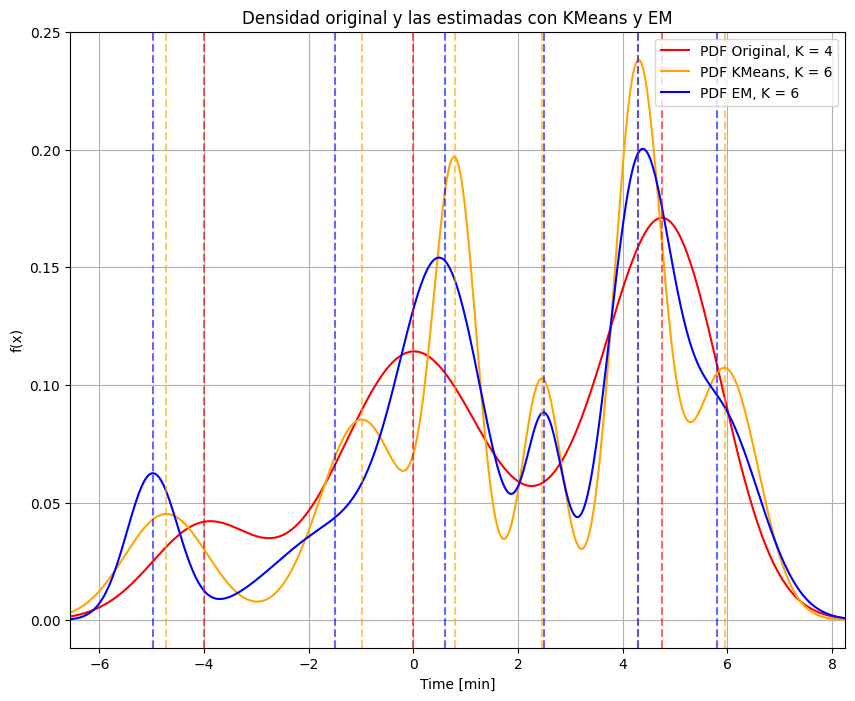

In [447]:
n_plot = 500

# Se estima la pdf de la mezcla, utilizando em
x_em,pdf_em,K_em= estimate_pdf_em(X, n_clusters = N_BEHAVIOR, n_pdf = n_plot)

print('\n\n')

# Se estima la pdf de la mezcla utilizando kmeans
x_kmeans,pdf_kmeans,K_kmeans = estimate_pdf_kmeans(X, n_clusters = N_BEHAVIOR, n_pdf = n_plot)


pdf_original = original_pdf

#### GRAFICOS

vlines1 = [original_means[0], original_means[1], 4.75] 
vlines2 = means_kmeans.tolist()
vlines3 = [5.8,4.3,-1.5,2.5,0.6,-4.98]

color1 = 'red'
color2 = 'orange'
color3 = 'blue'



# Se imprimen las pdf
plt.figure(figsize=(10,8))
plt.plot(x_plot,pdf_original, label =f'PDF Original, K = {K_original}', color = color1)
plt.plot(x_plot, pdf_kmeans, label = f'PDF KMeans, K = {K_kmeans}', color = color2)
plt.plot(x_plot,pdf_em, label = f'PDF EM, K = {K_em}', color = color3)


#### Se grafican las lineas verticales y se reinician los colores
plt.gca().set_prop_cycle(None)

for v in vlines1:
    plt.axvline(v, color=color1, linestyle="--", alpha=0.6)

for v in vlines2:
    plt.axvline(v, color=color2, linestyle="--", alpha=0.6)

for v in vlines3:
    plt.axvline(v, color=color3, linestyle="--", alpha=0.6)





plt.xlim([np.min(x_plot), np.max(x_plot)])
plt.title('Densidad original y las estimadas con KMeans y EM')
plt.xlabel('Time [min]')
plt.ylabel('f(x)')
plt.grid()
plt.legend()


En este caso, se observa que tanto KMeans como EM, no estiman bien la densidad verdadera. Se puede apreciar que para los tiempos en los que se producen los máximos de densidad en la distribución original, los algoritmos sobreestiman la densidad. Es decir, existe un overfitting, debido al valor K=6 que lleva a que los algoritmos fuercen la presencia de 6 clusters en los datos.
Por otro lado, EM puede producir overfitting, dado que puede colapsar las covarianzas que se utilizan para las gaussianas.

# Gaussian Variational Bayes

#### Sobre GVB

El algoritmo busca reemplazar la probabilidad a posteriori $ p(Z|X) $ (donde Z son las variables latentes, es decir, los parámetros de las gaussianas, los pesos y las etiquetas, de qué gaussianas provienen cada una de las muestras y las X son los datos observados) por una distribución más simple $p(Z)$ que se aproxime lo máximo posible a $p(Z|X)$
Para ello, toma una familia de distribuciones simples $q^*(Z)$ donde se seleccionará aquella que minimice la divergencia de Kullback-Leibler (KL) entre que $q$ y $p$:

$$
q^*(z) = arg_{q \in P}min KL {q(z|x)||p(z|x)}
$$.

Dicha divergencia, puede descomponerse como: 

$$
     KL (q(z|x)||p(z|x)) = log(p(x)) - ELBO (q(z|x))
$$

Donde:

$$
ELBO(q(z|x))  = H(q(z|x)) + \mathbb{E}[log(p(x,Z))| X=x ]
$$ 

donde $ H(q(z|x)) $ representa la entropía como función de x.

y 
$$
\mathbb{E}[log(p(x,Z))| X=x ]
$$

Es la entropía cruzada asociada a un autoencoder cuyo encoder es $q(z|x)$ y decoder $p(z|x)$



Minimizar la divergencia $KL$ es equivalente a maximizar la cota inferior de la evidencia es decir, la Evidence Lower BOund - ELBO.

La ELBO acota la verosimilitud de forma que maximizar una cota para la verosimilitud, permite maximizar la  misma $ELBO(q(z|x)) \leq log(p(x))$.

Para minimizar la divergencia $KL$, se asume sobre $P$ la restricción "Mean Field Approximation"  ($P$ es el espacio de la familia de funciones donde existe $q$). Dicha restricción asume que $q$ se puede factorizar como productos de densidades tratables, separando las variables ocultas $u$ y los parámetros $\phi$: (donde las $u$ son las etiquetas y los $\phi$ son los demás parámetros: los parámetros de las gaussianas y los pesos)

Es decir, sea:
$$
z=(u,\phi)
$$

se asume que :

$$
q(z|x) = q_1(u|x) q_2(\phi|x)
$$



#### Implementar un Variational Bayes Gaussiano que permita computar el modelo. Suponer a ki m = 0, δ = ν = β = 0.05 y α = (1, 1, 1, 1, 1, 1), y utilizar el algoritmo EM para inicializar las probabilidades. El entrenamiento debe contener doble condición de parada (número de iteraciones y convergencia). El algoritmo debe ser definido dentro de una clase que posea al menos los métodos init, fit, predict_proba y predict.

In [448]:
# "parameters" debe ser un diccionario con los parámetros a priori del modelo

class GVB:
    def __init__ (self, n_clusters = 6, parameters = None, init_gamma_ik = None):
        self.K = n_clusters

        if parameters is None:
            self.m0 = 0
            self.beta0 = 0.05
            self.nu0 = 0.05
            self.delta0 = 0.05
            self.alpha0 = np.ones(self.K)
        else:
            self.m0 = parameters['m']
            self.beta0 = parameters['beta']
            self.nu0 = parameters['nu']
            self.delta0 = parameters['delta']
            self.alpha0 = parameters['alpha']


        # Parámetros variacionales 
        self.gamma_ik = init_gamma_ik    
        self.alpha_k = None     # Parámetros de Dirichlet (pesos)
        self.m_k = None         # Esperanza de las medias
        self.delta_k = None  
        self.nu_k = None     
        self.beta_k = None   
        
    # Esta función actualiza el paso M, retorna un diccionario con los parámetros actualizados
    # Se pasa gamma_ik como parámetro por legibilidad del código en el bucle principal del entrenamiento
    def __update_params(self, X, gamma_ik):
    
        K = gamma_ik.shape[1] # K = 6
        
        # Se calculan las sumatorias para las fórmulas de actualización de los parámetros
        N_k = np.sum( gamma_ik, axis=0)        # sumatoria desde i= 1 hasta n de gamma_ik. Shape: (1,6) (n=100)
        f_k = gamma_ik.T @ X                # sumatoria desde i= 1 hasta n gamma_ik * x_i. Shape: (6,1) (n=100)
        X_squared = X**2                              # x^2 
        s_k = gamma_ik.T @ X_squared       # sumatoria desde i= 1 hasta n x_i^2 * gamma_ik. Shape: (6,1) (n=100)

        # Se inicializan los vectores de parámetros según los tamaños correspondientes
        alpha_k_star = np.zeros(K)
        m_k_star = np.zeros((K))
        delta_k_star = np.zeros(K)
        nu_k_star = np.zeros(K)
        beta_k_star = np.zeros(K)

        for k in range(K):

            # Cálculo de alpha_k* 
            alpha_k_star[k] = self.alpha0[k] + N_k[k]

            # Cálculo de delta_k*
            delta_k_star[k] = self.delta0 + N_k[k]
            
            # Cálculo de m_k*
            m_k_star[k] = (self.delta0 * self.m0 + f_k[k]) / delta_k_star[k]
        
            # Cálculo de nu_k*
            nu_k_star[k] = self.nu0 + 0.5 * N_k[k]

            # Cálculo de beta_k*
            term_1 = self.beta0
            term_2 = 0.5 * self.delta0 * self.m0**2
            term_3 = 0.5 * s_k [k]

            num = self.delta0 * self.m0 + f_k[k]
            den = 2 * (self.delta0 + N_k[k])

            term_4 = - (num**2) / den

            beta_k_star[k] = term_1 + term_2 + term_3 + term_4

        
        return {
            'alpha_k_star': alpha_k_star, 'm_k_star': m_k_star, 
            'delta_k_star': delta_k_star, 'nu_k_star': nu_k_star, 
            'beta_k_star': beta_k_star
            }

    # Función privada para el cálculo del paso E.
    # Se pasa por parámetro los parámetros actualizados del modelo por legibilidad del código.
    def __update_gamma(self, X, params_star):

        alpha_k_star = params_star['alpha_k_star']
        m_k_star = params_star['m_k_star']
        delta_k_star = params_star['delta_k_star']
        nu_k_star = params_star['nu_k_star']
        beta_k_star = params_star['beta_k_star']

        N = X.shape[0]
        
        K = alpha_k_star.shape[0]
        
        N_k = np.sum(alpha_k_star)

        prob_ik = np.zeros((N, K))
        
        for k in range(K):
            
            term_1 = digamma(alpha_k_star[k])
            term_2 = - digamma(N_k)
            
            term_3 = ( digamma(nu_k_star[k]) - np.log(beta_k_star[k]) ) * 0.5

            term_4 = - 1 / (2 * delta_k_star[k])

            term_5 = - (nu_k_star[k] / (2 * beta_k_star[k]) )   *   ((m_k_star[k] - X) ** 2)

            prob_ik[:, k] = np.exp(term_1 + term_2 + term_3 + term_4 + term_5)

        gamma_ik_new = prob_ik / np.sum(prob_ik, axis=1, keepdims=True)

        return gamma_ik_new
    
    def fit(self, X, max_iter=500, tol=1e-6):

        K = self.gamma_ik.shape[1]
        
        X = X.ravel()
        
        for i in range(max_iter):
            old_gamma_ik = self.gamma_ik.copy()

            # Se actualizan los parámetros de Maximización - Paso M
            # Se pasa gamma_ik de forma explícita por claridad del código
            params_star = self.__update_params (X, self.gamma_ik)

            # Se actualizan las responsabilidades - Paso E
            # Se pasa params_star por claridad del codigo
            self.gamma_ik = self.__update_gamma(X, params_star)

            # Se calcula la el error promedio entre las responsabilidades, para analizar si el algoritmo converge
            diff = np.sum(np.abs(self.gamma_ik - old_gamma_ik)) / X.shape[0]

            # Si el algoritmo converge, se corta el bucle
            if diff < tol: 
                print(f"Convergencia alcanzada en la iteración {i+1}. Error promedio: {diff:.6f}")
                break

        self.alpha_k = params_star['alpha_k_star']
        self.m_k = params_star ['m_k_star']
        self.delta_k = params_star ['delta_k_star']
        self.nu_k = params_star ['nu_k_star']
        self.beta_k = params_star ['beta_k_star']



    # Predicción Soft
    def predict_proba (self,X):

        # Se crea el diccionario de parámetros 
        params = {
            'alpha_k_star': self.alpha_k, 'm_k_star': self.m_k, 
            'delta_k_star': self.delta_k, 'nu_k_star': self.nu_k, 
            'beta_k_star': self.beta_k
            }

        # Se calculan las responsabilidades utilizando los parámetros finales del modelo
        return self.__update_E_step_gamma(X, params)
    
    # Predicción Hard
    def predict(self, X):
        gamma = self.predict_proba(X)
        return np.argmax(gamma)
    




    # Método para obtener las muestras de los parámetros de las gaussianas 
    def sample_parameters(self):
        # Se obtienen las muestras de los pesos, que poseen distribución dirichlet de parámetros alpha_k
        pi = np.random.dirichlet(self.alpha_k)

        # Se obtienen las muestras de las lambdas, con distribución gamma
        lambdas = np.random.gamma(shape=self.nu_k, scale=1/self.beta_k)

        # Se obtienen las muestras de las medias, con distribución gaussiana
        means = np.random.normal(loc=self.m_k, scale=np.sqrt(1/(self.delta_k * lambdas)))

        return pi, means, lambdas


In [449]:
em_model = EM(n_clusters= N_BEHAVIOR)

# entrenamiento EM
em_model.fit(X)

# Se obtienen las responsabilidades
resp = em_model.resp

K_gvb = 6

gvb_model = GVB(n_clusters= K_gvb, init_gamma_ik= resp)

# entrenamiento GVB
gvb_model.fit(X)

Convergencia alcanzada en la iteración 188. Error promedio: 0.000001


#### Con la distribución a posteriori generar 3 muestras de parámetros y graficar la densidad de X|µ, λ, π para cada uno de esos conjuntos de parámetros. Compararla con la densidad verdadera, con la de K-means y con la del EM.

##### Funciones

In [450]:
# Función para calcular la pdf gaussiana, considerando los tamaños de los arryas
def gaussian_pdf_gvb (x, mean, std):
    x = x.reshape(-1,1)      # shape (500,1)
    mean = mean.reshape(1,-1)  # shape (1,K)
    std = std.reshape(1,-1)
    coef = 1.0 / (std * np.sqrt(2*np.pi))
    exp = np.exp(-0.5 * ((x - mean)/std)**2)
    return coef * exp        # shape (500, K)

##### Gráficos

weights_gvb (6,)
means_gvb (6,)
lambdas (6,)


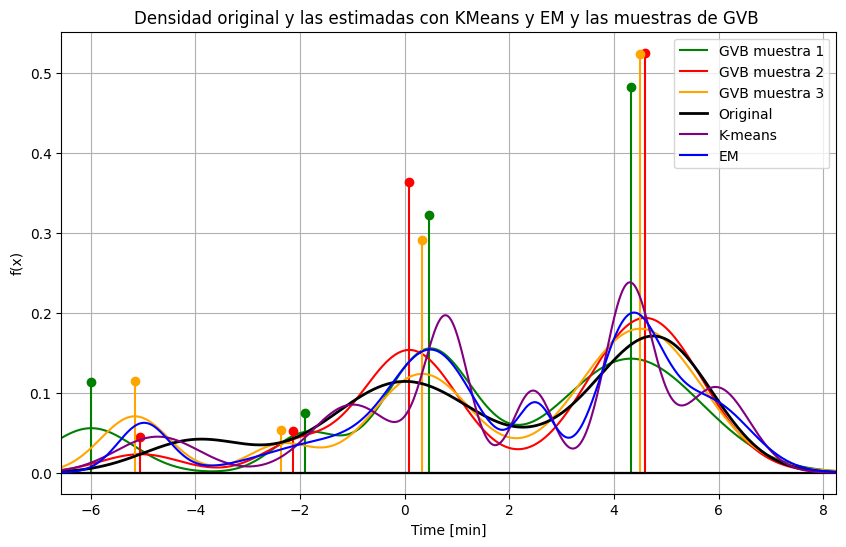

In [451]:
n_pdf = 500
# Se generan los tiempos en min para la pdf
x_plot = np.linspace(np.min(X)-1 , np.max(X)+1 ,n_pdf)

###### GRAFICOS

vlines1 = [original_means[0], original_means[1], 4.75] 
vlines2 = means_kmeans.tolist()
vlines3 = [5.8,4.3,-1.5,2.5,0.6,-4.98] #EM


color1 = 'black'
color2 = 'purple'
color3 = 'blue'

plt.figure(figsize=(10,6))

vlines_gvb = []
stem_gvb = []
colors = ['green','red','orange']

for s in range(3):

    # Se calculan los parámetros con el GVB entrenado
    weights_gvb, means_gvb, lambdas = gvb_model.sample_parameters()
    stds = np.sqrt(1/lambdas)

    if s==1 :
        print('weights_gvb', weights_gvb.shape)
        print('means_gvb', means_gvb.shape)
        print('lambdas', lambdas.shape)

    # Se obtiene la pdf de cada componente, resultando en una matriz de (500,K)
    comp_pdfs = gaussian_pdf_gvb(x_plot, mean=means_gvb, std=stds)

    # Se mezclan las componentes, generando un array de (500,)
    pdf_sample = comp_pdfs @ weights_gvb  # shapes: (500,K) x (K,)

    plt.plot(x_plot, pdf_sample, label=f"GVB muestra {s+1}",color=colors[s])
    markerline, stemlines, baseline = plt.stem(means_gvb, weights_gvb)
    plt.setp(markerline, color=colors[s])   # color del marcador
    plt.setp(stemlines, color=colors[s])    # color de las líneas verticales
    plt.setp(baseline, color='k')           # opcional: color de la base


plt.plot(x_plot, pdf_original, label='Original', linewidth=2, color =color1)
plt.plot(x_plot, pdf_kmeans, label='K-means', color =color2)
plt.plot(x_plot, pdf_em, label='EM', color =color3)






plt.xlim([np.min(x_plot), np.max(x_plot)])
plt.title('Densidad original y las estimadas con KMeans y EM y las muestras de GVB ')
plt.xlabel('Time [min]')
plt.ylabel('f(x)')
plt.grid()
plt.legend()

En este caso, las densidades por separado de los parámetros de GVB obtenidos, tienen comportamientos similares. En general se sobreestiman las densidades para los tiempos cercanos a 0 y 5 min. Aunque se evidencia que las muestras hacen un mejor trabajo para la estimación de la densidad en torno a los 5min. Esto puede corregirse a medida que se asignan pesos en la mezcla de gaussianas en el cálculo de GVB. Esta asignación de pesos, permite promediar de una mejor manera las densidades, generando una mejor estimación de la densidad original.

#### Graficar la densidad predictiva. Compararla con la densidad verdadera, con la de K-means y con la del EM.

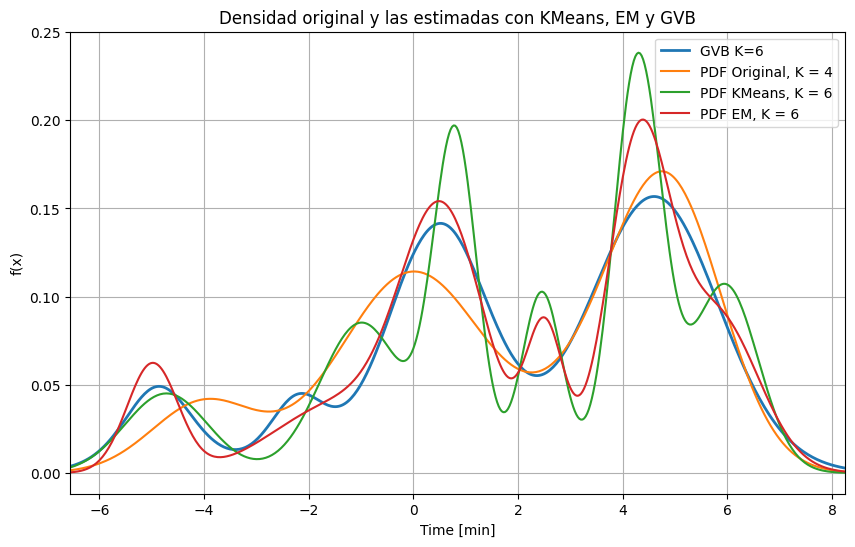

In [452]:
x_plot = np.linspace(X.min()-1, X.max()+1, n_plot)

# Se define la cantidad de muestras de los parámetros
S = 100

# Se define el tamaño de los datos de la pdf a graficar para que coincida con x_plot
pdf_gvb = np.zeros_like(x_plot)


for s in range(S):

    # Se obtienen parámetros de tamaños (K,)    
    weights_gvb, means_gvb, lambdas = gvb_model.sample_parameters()

    # Se genera un array de ceros de tamaño n_plot
    mix_pdf = np.zeros_like(x_plot)

    # Se suman las K componentes, utilizando los K parámetros para las gaussianas
    # es decir, se calcula la mezcla de las K gaussianas para la muestra s
    for k in range(K_gvb):
        comp = gaussian_pdf(x_plot, means_gvb[k], np.sqrt(1/lambdas[k]))
        mix_pdf += weights_gvb[k] * comp


    # Se suma en la pdf final, el resultado de la iteración (se suman las S mezclas)
    pdf_gvb += mix_pdf

# Se normaliza dividiendo por la cantidad de muestras de las gaussianas utilizadas
pdf_gvb /= S

plt.figure(figsize=(10,6))

plt.plot(x_plot, pdf_gvb, label='GVB K=6', linewidth=2)
plt.plot(x_plot,pdf_original, label =f'PDF Original, K = {K_original}')
plt.plot(x_plot, pdf_kmeans, label = f'PDF KMeans, K = {K_kmeans}')
plt.plot(x_plot,pdf_em, label = f'PDF EM, K = {K_em}')
plt.xlim([np.min(x_plot), np.max(x_plot)])
plt.xlim([np.min(x_plot), np.max(x_plot)])
plt.title('Densidad original y las estimadas con KMeans, EM y GVB')
plt.xlabel('Time [min]')
plt.ylabel('f(x)')
plt.grid()
plt.legend()

En este último caso, puede apreciarse que GVB estima muy bien la densidad original, mientras que KMeans y EM no hacen un buen trabajo, ya que fuerzan la aparición de los 6 clusters, mientras que GVB promedia las distribuciones (obtenidas a partir de las muestras de los parámetros) con distintos pesos. La tendencia general demuestra que GVB ajusta mejor el comportamiento de los datos.

En definitiva, dado que GVB utiliza gaussianas con distintos pesos, permite modelar de una mejor manera las densidades, apagando aquellas componentes que no tienen gran relevancia, mientras que aquellas que describen el comportamiento de los datos, tienen mayor peso.